<a href="https://colab.research.google.com/github/IvanKatorgin/Deep-Learning/blob/main/Deep_Learning_%D0%B4%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Курс "Deep Learning". Домашнее задание 13. Работа с текстом. Каторгин И.П.

## Задание
1. Скачать датасет с фразами Симпсонов - https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data
2. Обучить word2vec на фразах персонажей
3. Визуализировать embeddings по самым частотным словам (top 1000)
4. Найти самые близкие слова для: homer - marge + bart bart - lisa + school marge - homer + home
5. Попробовать построить классификатор bart/lisa с использованием этих эмбеддингов (необязательно)

In [1]:
# загрузим библиотеки
!pip install gensim
!pip install compress-fasttext

  Using cached compress-fasttext-0.1.5.tar.gz (15 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for compress-fasttext: filename=compress_fasttext-0.1.5-py3-none-any.whl size=16098 sha256=385ab3c43797e2a74b5935287549f135f322010fa012f2ed78c06a376353d03b
  Stored in directory: /root/.cache/pip/wheels/90/ed/77/0a7fc5e08ff30e062f09c6904844a5911a9e30a7e5ec376890
Successfully built compress-fasttext


In [93]:
import pandas as pd
from gensim import models
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from collections import Counter
import numpy as np

In [3]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(x, y):
    return dot(x, y) / (norm(x) * norm(y))

print(cos_sim([1, 0, 0], (1, 0, 0)))
print(cos_sim([1, 0, 0], (0, 1, 0)))
print(cos_sim([1, 0, 0], (-1, 0, 0)))

1.0
0.0
-1.0


In [7]:
# загрузим датасет с фразами с github
!git clone https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data

Cloning into 'Text-mining-with-Simpsons-Data'...
remote: Enumerating objects: 21, done.
remote: Total 21 (delta 0), reused 0 (delta 0), pack-reused 21 (from 1)
Receiving objects: 100% (21/21), 8.95 MiB | 16.90 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [8]:
# распакуем датасет simpsons_script_lines
!unzip Text-mining-with-Simpsons-Data/simpsons_script_lines.csv.zip

Archive:  Text-mining-with-Simpsons-Data/simpsons_script_lines.csv.zip
  inflating: simpsons_script_lines.csv  


In [13]:
# загрузим файл с фразами
df = pd.read_csv('simpsons_script_lines.csv', sep=',', quotechar='"', on_bad_lines='warn')
df.head()

/tmp/ipython-input-13-507555523.py:2: ParserWarning: Skipping line 8084: expected 13 fields, saw 20
Skipping line 52607: expected 13 fields, saw 21
Skipping line 59910: expected 13 fields, saw 21

  df = pd.read_csv('simpsons_script_lines.csv', sep=',', quotechar='"', on_bad_lines='warn')
/tmp/ipython-input-13-507555523.py:2: ParserWarning: Skipping line 71801: expected 13 fields, saw 20
Skipping line 73539: expected 13 fields, saw 21
Skipping line 77230: expected 13 fields, saw 21
Skipping line 78953: expected 13 fields, saw 21
Skipping line 81138: expected 13 fields, saw 20
Skipping line 86746: expected 13 fields, saw 22
Skipping line 101154: expected 13 fields, saw 21
Skipping line 115438: expected 13 fields, saw 20
Skipping line 117573: expected 13 fields, saw 22
Skipping line 130610: expected 13 fields, saw 22

  df = pd.read_csv('simpsons_script_lines.csv', sep=',', quotechar='"', on_bad_lines='warn')
/tmp/ipython-input-13-507555523.py:2: ParserWarning: Skipping line 152970: expe

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31.0
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3.0
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22.0
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living,5.0
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,True,40.0,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...,33.0


In [10]:
# загрузим файл с фразами
df = pd.read_csv('simpsons_script_lines.csv', sep=',', quotechar='"', on_bad_lines='skip', encoding='latin1')
df.head()

/tmp/ipython-input-10-1213250459.py:2: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('simpsons_script_lines.csv', sep=',', quotechar='"', on_bad_lines='skip', encoding='latin1')


,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31.0
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3.0
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22.0
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living,5.0
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,True,40.0,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...,33.0


In [16]:
# проверим пропуски в датасете
df.isnull().sum()

,0
id,0
episode_id,0
number,0
raw_text,0
timestamp_in_ms,0
speaking_line,0
character_id,17521
location_id,407
raw_character_text,17522
raw_location_text,408


In [17]:
# Удалим строки с пропусками
df = df.dropna(subset=['normalized_text'])

In [18]:
# создадим список нормализованных фраз из датасета
sentences = []
for line in df['normalized_text']:
    sentences.append(line.split(' '))
print(sentences[0])

['no', 'actually', 'it', 'was', 'a', 'little', 'of', 'both', 'sometimes', 'when', 'a', 'disease', 'is', 'in', 'all', 'the', 'magazines', 'and', 'all', 'the', 'news', 'shows', 'its', 'only', 'natural', 'that', 'you', 'think', 'you', 'have', 'it']


In [19]:
# создадим модель Word2Vec
model = models.Word2Vec()
model.build_vocab(sentences)
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)

(4779139, 6529935)

Визуализируем embeddings по самым частотным словам (top 1000)

In [23]:
# Считаем частоту слов
word_counts = Counter([word for sentence in sentences for word in sentence])
top_words = [word for word, _ in word_counts.most_common(1000)]

In [24]:
# Фильтруем слова, присутствующие в модели
top_words = [word for word in top_words if word in model.wv]

In [25]:
# Получаем вектора слов
word_vectors = np.array([model.wv[word] for word in top_words])

In [26]:
# Уменьшаем размерность до 2D
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(word_vectors)

In [27]:
# Создаем DataFrame для удобства
df_plot = pd.DataFrame({
    'word': top_words,
    'x': vectors_2d[:, 0],
    'y': vectors_2d[:, 1]
})

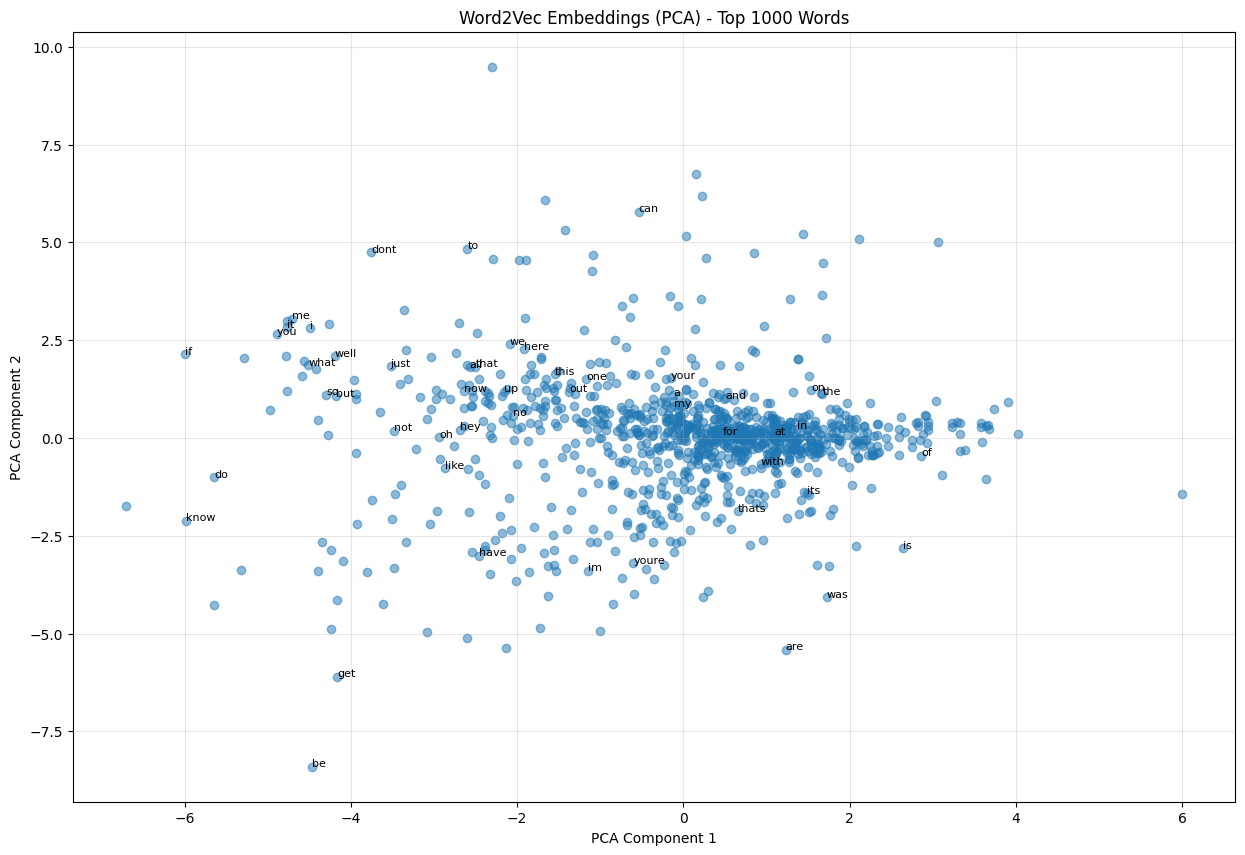

In [28]:
# визуализируем
plt.figure(figsize=(15, 10))
plt.scatter(df_plot['x'], df_plot['y'], alpha=0.5)

# Подписываем часть слов (первые 50 для наглядности)
for i, word in enumerate(top_words[:50]):
    plt.annotate(word, xy=(df_plot['x'][i], df_plot['y'][i]), fontsize=8)

plt.title('Word2Vec Embeddings (PCA) - Top 1000 Words')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(alpha=0.3)
plt.show()

In [29]:
# интерактивная визуализация
import plotly.express as px
fig = px.scatter(df_plot, x='x', y='y', text='word', hover_name='word')
fig.update_traces(textposition='top center', marker=dict(size=5))
fig.show()

Удалим стоп слова и все повторим без них

In [31]:
# Установка стоп-слов (если не сделано ранее)
import nltk
nltk.download('stopwords')

# Импорт стоп-слов
from nltk.corpus import stopwords

# Фильтрация стоп-слов
stop_words = set(stopwords.words('english'))
top_words = [word for word in top_words if word not in stop_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [32]:
print(stopwords.words('english')[:10])  # Пример: ['i', 'me', 'my', 'myself', 'we', ...]

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']


In [ ]:
# удалим стоп-слова из нашего списка
top_words = [word for word in top_words if word not in stop_words]
print(top_words[:10])

In [33]:
# Функция для удаления стоп-слов из одного предложения
def remove_stopwords(word_list):
    return [word for word in word_list if word.lower() not in stop_words]

In [34]:
# Применяем ко всем предложениям
sentences_clean = [remove_stopwords(sentence) for sentence in sentences]

In [35]:
# Проверяем результат
print("До очистки:", sentences[0])
print("После очистки:", sentences_clean[0])

До очистки: ['no', 'actually', 'it', 'was', 'a', 'little', 'of', 'both', 'sometimes', 'when', 'a', 'disease', 'is', 'in', 'all', 'the', 'magazines', 'and', 'all', 'the', 'news', 'shows', 'its', 'only', 'natural', 'that', 'you', 'think', 'you', 'have', 'it']
После очистки: ['actually', 'little', 'sometimes', 'disease', 'magazines', 'news', 'shows', 'natural', 'think']


In [36]:
# создадим модель Word2Vec
model = models.Word2Vec()
model.build_vocab(sentences_clean)
model.train(sentences_clean, total_examples=model.corpus_count, epochs=model.epochs)

(3116091, 3693300)

Визуализируем embeddings по самым частотным словам (top 1000)

In [37]:
# Считаем частоту слов
word_counts = Counter([word for sentences_clean in sentences_clean for word in sentences_clean])
top_words = [word for word, _ in word_counts.most_common(1000)]

In [38]:
# Фильтруем слова, присутствующие в модели
top_words = [word for word in top_words if word in model.wv]

In [39]:
# Получаем вектора слов
word_vectors = np.array([model.wv[word] for word in top_words])

In [40]:
# Уменьшаем размерность до 2D
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(word_vectors)

In [41]:
# Создаем DataFrame для удобства
df_plot = pd.DataFrame({
    'word': top_words,
    'x': vectors_2d[:, 0],
    'y': vectors_2d[:, 1]
})

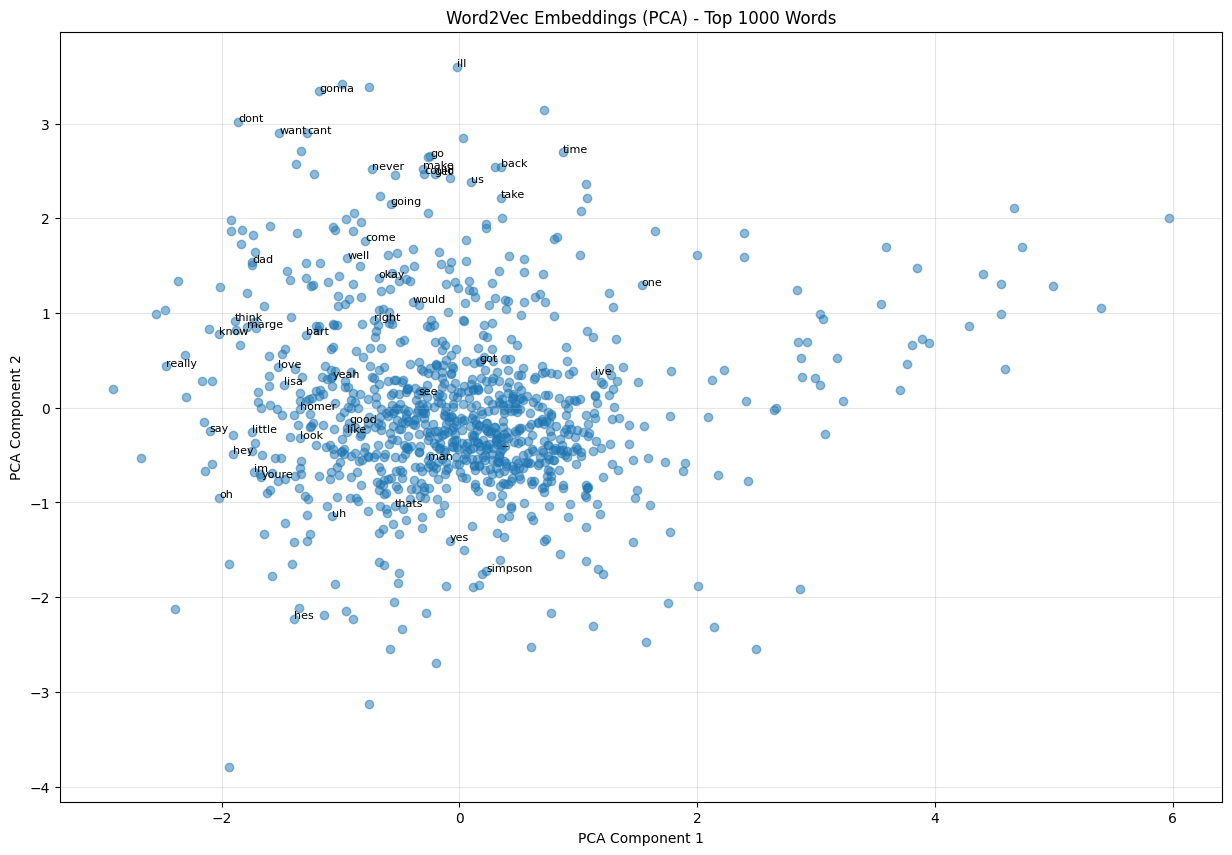

In [42]:
# визуализируем
plt.figure(figsize=(15, 10))
plt.scatter(df_plot['x'], df_plot['y'], alpha=0.5)

# Подписываем часть слов (первые 50 для наглядности)
for i, word in enumerate(top_words[:50]):
    plt.annotate(word, xy=(df_plot['x'][i], df_plot['y'][i]), fontsize=8)

plt.title('Word2Vec Embeddings (PCA) - Top 1000 Words')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(alpha=0.3)
plt.show()

In [43]:
# интерактивная визуализация
import plotly.express as px
fig = px.scatter(df_plot, x='x', y='y', text='word', hover_name='word')
fig.update_traces(textposition='top center', marker=dict(size=5))
fig.show()

После удаления стоп-слов результат получился интереснее

Найти самые близкие слова для:

homer - marge + bart

bart - lisa + school

marge - homer + home

In [46]:
# Вычисляем близкие слова для: homer - marge + bart
result = model.wv.most_similar(positive=['homer', 'bart'], negative=['marge'], topn=5)

# Выводим топ-5 результатов
print("homer - marge + bart = ")
for word, similarity in result:
    print(f"{word}: {similarity:.4f}")

homer - marge + bart = 
lisa: 0.8282
j: 0.7224
genes: 0.7107
mrs: 0.7062
abe: 0.6979


In [48]:
# Вычисляем близкие слова для: bart - lisa + school
result = model.wv.most_similar(positive=['bart', 'school'], negative=['lisa'], topn=5)

# Выводим топ-5 результатов
print("bart - lisa + school = ")
for word, similarity in result:
    print(f"{word}: {similarity:.4f}")

bart - lisa + school = 
town: 0.7971
high: 0.7943
rest: 0.7756
bus: 0.7746
tomorrow: 0.7675


In [49]:
# Вычисляем близкие слова для: marge - homer + home
result = model.wv.most_similar(positive=['marge', 'home'], negative=['homer'], topn=5)

# Выводим топ-5 результатов
print("marge - homer + home = ")
for word, similarity in result:
    print(f"{word}: {similarity:.4f}")

marge - homer + home = 
bed: 0.8574
sleep: 0.8079
outta: 0.7794
back: 0.7762
run: 0.7731


Построим классификатор bart/lisa с использованием эмбеддингов

In [54]:
# создадим модель Word2Vec
model = models.Word2Vec()
model.build_vocab(sentences)
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)

(4775417, 6529935)

In [59]:
# Фильтрация данных
bart_lisa_mask = df['raw_character_text'].isin(['Bart Simpson', 'Lisa Simpson'])
df_bart_lisa = df[bart_lisa_mask].copy()

In [60]:
# Создание меток
y = df_bart_lisa['raw_character_text'].apply(lambda x: 1 if 'Bart' in x else 0).values

In [61]:
# Фильтрация предложений
sentences_clean = [sent for sent, keep in zip(sentences_clean, bart_lisa_mask) if keep]

In [62]:
# Создание эмбеддингов для предложений
def get_sentence_embedding(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

In [63]:
# Создание эмбеддингов
X = np.array([get_sentence_embedding(sentence, model) for sentence in sentences_clean])

In [64]:
# Проверка размеров
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (23775, 100), y shape: (23775,)


In [65]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
# Обучаем классификатор
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

RandomForestClassifier()

In [67]:
# Оценка
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.46      0.52      2195
           1       0.61      0.73      0.67      2560

    accuracy                           0.61      4755
   macro avg       0.60      0.60      0.59      4755
weighted avg       0.61      0.61      0.60      4755



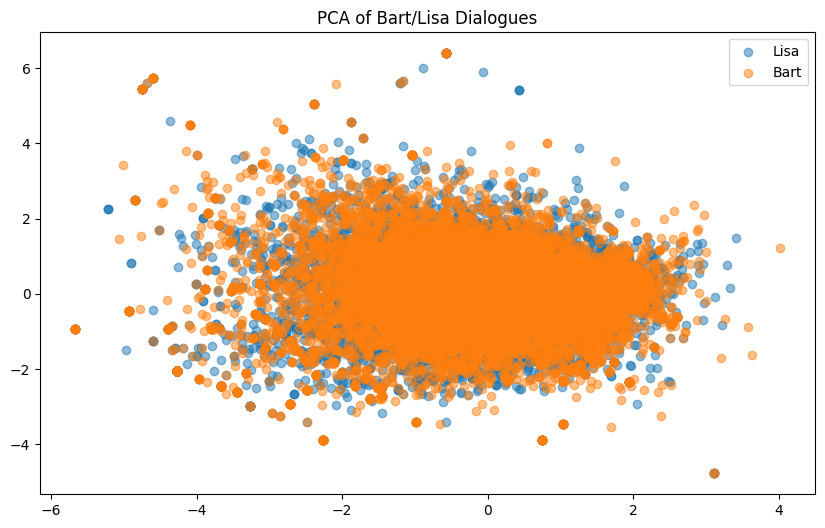

In [68]:
# Визуализируем
# Уменьшаем размерность для визуализации
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Рисуем
plt.figure(figsize=(10, 6))
plt.scatter(X_2d[y==0, 0], X_2d[y==0, 1], alpha=0.5, label='Lisa')
plt.scatter(X_2d[y==1, 0], X_2d[y==1, 1], alpha=0.5, label='Bart')
plt.legend()
plt.title('PCA of Bart/Lisa Dialogues')
plt.show()

In [69]:
# Интерпретация
# Для RandomForest
importances = clf.feature_importances_
top_words_idx = importances.argsort()[-10:][::-1]

# Сопоставляем индексы с исходными словами (примерно)
vocab = list(model.wv.key_to_index.keys())
print("Важные слова для классификации:", [vocab[i] for i in top_words_idx])

Важные слова для классификации: ['from', 'never', 'an', 'for', 'im', 'do', 'thats', 'youre', 'look', 'cant']


Выводы:
1. Обучена модель word2vec на фразах персонажей Симпсонов
2. Визуализированы embeddings по самым частотным словам со стоп-словами и без стоп-слов
3. Найдены самые близкие слова для:
- homer - marge + bart
- bart - lisa + school
- marge - homer + home
4. Построен классификатор bart/lisa